In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt


In [2]:
import numpy as np
import pandas as pd
import datetime as dt


# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func


In [4]:
# Create engine using the `hawaii.sqlite` database file
engine = create_engine("sqlite:///Resources/hawaii.sqlite")


In [10]:
# Declare a Base using `automap_base()`
Base = automap_base()
# Use the Base class to reflect the database tables
Base.prepare(autoload_with = engine)

In [11]:
# Print all of the classes mapped to the Base
print(Base.classes.keys())

['measurement', 'station']


In [12]:
# Assign the measurement class to a variable called `Measurement` and
# assign the station class to a variable called `Station`
Measurement = Base.classes.measurement
Station = Base.classes.station

In [13]:
# Create a session
session = Session(engine)

In [14]:
# Print the attributes of the Measurement class
print(Measurement.__dict__.keys())


dict_keys(['__table__', '__module__', '__doc__', '_sa_class_manager', '__init__', 'id', 'station', 'date', 'prcp', 'tobs', '__mapper__'])


In [15]:
# Print the attributes of the Station class
print(Station.__dict__.keys())

dict_keys(['__table__', '__module__', '__doc__', '_sa_class_manager', '__init__', 'id', 'station', 'name', 'latitude', 'longitude', 'elevation', '__mapper__'])


# Exploratory Precipitation Analysis

In [19]:
# Find the most recent date in the data set.
recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
recent_date

('2017-08-23',)

         date  prcp
0  2016-08-23   0.0
1  2016-08-23   3.8
2  2016-08-23   1.3
3  2016-08-23   NaN
4  2016-08-23   0.5


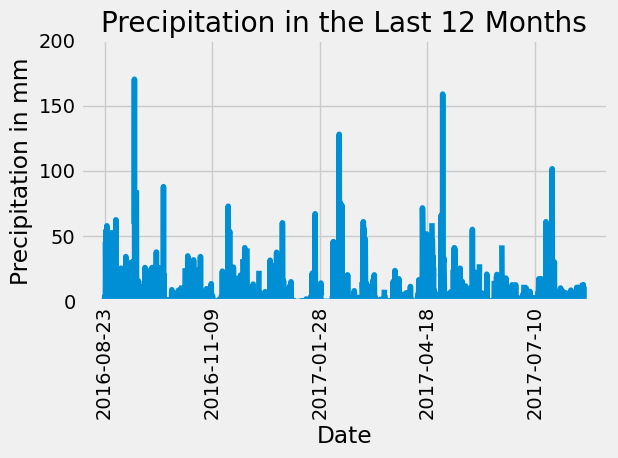

In [27]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results.
# Starting from the most recent data point in the database.
most_recent_date = dt.datetime.strptime(recent_date[0], '%Y-%m-%d')

# Calculate the date one year from the last date in data set.
one_year_ago = most_recent_date - dt.timedelta(days=365)
one_year_ago = one_year_ago.strftime('%Y-%m-%d')

# Perform a query to retrieve the data and precipitation scores
precipitation = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= one_year_ago).\
    order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
precipitation_df = pd.DataFrame(precipitation, columns=['date', 'prcp'])
print(precipitation_df.head())

# Sort the dataframe by date
precipitation_df = precipitation_df.sort_values(by='date')
precipitation_df.head()

# Use Pandas Plotting with Matplotlib to plot the data
precipitation_df.plot(x='date', y='prcp', kind='line', legend=False)
plt.title('Precipitation in the Last 12 Months')
plt.xlabel('Date')
plt.ylabel('Precipitation in mm')
plt.xticks(rotation=90)
plt.ylim(0,200)
plt.tight_layout()
plt.show()

In [28]:
# Use Pandas to calculate the summary statistics for the precipitation data
precipitation_summary = precipitation_df['prcp'].describe()
print(precipitation_summary)

count    2021.000000
mean        4.505888
std        11.713487
min         0.000000
25%         0.000000
50%         0.500000
75%         3.300000
max       170.200000
Name: prcp, dtype: float64


# Exploratory Station Analysis

In [41]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(Station.station)).scalar()
total_stations

9

In [42]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
active_stations = session.query(Measurement.station, func.count(Measurement.station).label('count')).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()

# Print the results
for station, count in active_stations:
    print(f"Station: {station}, Count: {count}")

Station: USC00519281, Count: 2772
Station: USC00519397, Count: 2724
Station: USC00513117, Count: 2709
Station: USC00519523, Count: 2669
Station: USC00516128, Count: 2612
Station: USC00514830, Count: 2202
Station: USC00511918, Count: 1979
Station: USC00517948, Count: 1372
Station: USC00518838, Count: 511


In [46]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
# get the most active station which would be the first row
most_active_station = session.query(Measurement.station, func.count(Measurement.station).label('count')).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).first()[0]
print(f"Most active station: {most_active_station}")

# Calculate the lowest, highest, and average temperature for the most active station
temperature_stats = session.query(
    func.min(Measurement.tobs).label('min_temp'),
    func.max(Measurement.tobs).label('max_temp'),
    func.avg(Measurement.tobs).label('avg_temp')
).filter(Measurement.station == most_active_station).first()

# Extracting the results
min_temp = temperature_stats[0]
max_temp = temperature_stats[1]
avg_temp = temperature_stats[2]

print(f"Min Temp: {min_temp}, Max Temp: {max_temp}, Average Temp: {avg_temp}")

Most active station: USC00519281
Min Temp: 12.2, Max Temp: 29.4, Average Temp: 22.03582251082252


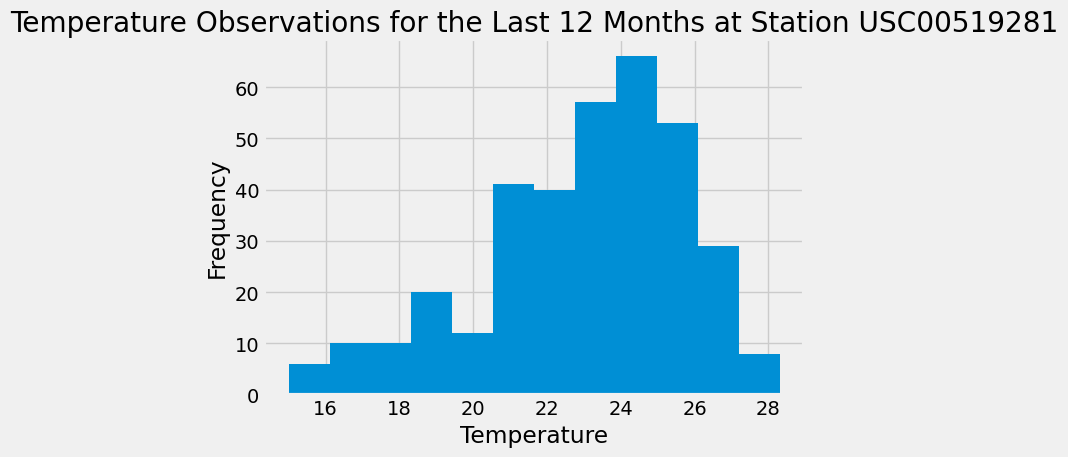

In [49]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temperature_data = session.query(Measurement.tobs).\
    filter(Measurement.station == most_active_station).\
    filter(Measurement.date >= one_year_ago).all()

# Convert the query results to a Pandas DataFrame
temperature_df = pd.DataFrame(temperature_data, columns=['tobs'])

# Plot the results as a histogram
plt.hist(temperature_df['tobs'], bins=12)
plt.title('Temperature Observations for the Last 12 Months at Station {}'.format(most_active_station))
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()



# Close Session

In [50]:
# Close Session
session.close()
